# Variants of Stochastic Gradients Algorithms

Consider problem
$$
\tag{1.1} R(w)=\min \limits_{w\in\mathbb{R}^d} {\frac{1}{n}\sum_{i=1}^{n}{f_i(w)+\lambda\|w\|_1}}
$$
where $f_i(w)=\log(1+\exp(-y^iw^\mathrm{T} x^i))$ and $\lambda > 0$

## Write down and implement two of the following algorithms:  Adadelta, AdagradDA, Adagrad, ProximalAda-grad, Ftrl, Momentum, adam, Momentum, CenteredRMSProp, nesterov, rmsprop, SAG, SAGA, SVRG

### Calculate sub-gradient

We let $L(w)=\frac{1}{n}\sum_{i=1}^{n}{f_i(w)}$ and consider problem $(1.1)$ with the general form:
$$
\tag{1.2} \min\limits_{w\in\mathbb{R}^d} {R(w)\triangleq L(w)+\lambda\|w\|_1}
$$
Here, $L(x)$ is a twice-differentiable loss function that is bounded from below, and the goal is to minimize this loss function with the $\ell_1$-regularization.

Then, we drive the gradient of problem $(1.2)$. Since the combined objective function $R(w)$ is non-differentiable when $w$ contains values of 0, this precludes the use of standard unconstrained optimization methods. To deal with this problem, we use **sub-gradient strategies** referred to Section 2 in *Optimization Methods for $\ell_1$-Regularization*. We first examine optimization strategies that treat the non-differentiable objective as a non-smooth optimization problem, by using sub-gradients of the objective function at non-differentiable points.  

We might also consider selecting (coordinate-wise) the following sub-gradient $\nabla_i^s R(w_i)$ for each $w_i$, whose negation represents the *steepest descent direction*:

$$
\nabla_i^s R(w) \triangleq
\begin{cases}
\nabla_i L(w)+\lambda\,\text{sign}(w_i) & \left|w_i\right|>0 \\
\nabla_i L(w)+\lambda  & w_i = 0,\nabla_i L(w) < -\lambda\\
\nabla_i L(w)-\lambda  & w_i = 0,\nabla_i L(w) > \lambda\\
0 & w_i = 0, -\lambda\leq\nabla_i L(w) \leq\lambda
\end{cases}
$$

In which we can easily derive the first-order derivative of $L(w)$:
$$
\nabla L(w) = \frac{1}{n}\sum_{i=1}^{n}{x^iy^i\left(\frac{1}{1+\exp(-y^iw^\mathrm{T}x^i)}-1\right)}
$$

In [1]:
import numpy as np
from random import sample
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# calculate gradient of L(w)
def L_grad(w, x, y):
    d, n = x.shape
    l_grad = np.zeros(d)
    for i in xrange(n):
        xy = x[:,i]*y[i]
        exp = math.exp(-w.T.dot(xy))
        l_grad += xy*(1./(1+exp)-1)
   
    l_grad *= 1./n
    
    return l_grad


# calculate gradient of g(w)
def g_grad(w, x, y, lamda):
    l_grad = L_grad(w, x, y)
    d = l_grad.shape[0]
    grad = np.zeros(d)
    
    for i in xrange(d):
        if np.abs(w[i]) > 0:
            grad[i] = l_grad[i]+lamda*np.sign(w[i])
        else:
            grad[i] = np.maximum(np.abs(l_grad[i]) - lamda, 0.) * np.sign(l_grad[i])
    
    return grad

### Evaluation metrics

参考论文*Exact and Inexact Subsampled Newton Methods for Optimization*的FigureA.7，文中横坐标分别选取Iterations，Effective Gradient Evaluations，Time(s)作为评价指标。由于论文中使用的是二阶算法，而我们的一阶算法不需要估计$g(w)$，因此我们不考虑Effective Gradient Evaluations这个评价指标。文中的纵坐标使用了$training\,error$和$testing\,error$。$training\,error$定义为$R(w)-R(w^*)$，其中$R$由训练集里的点给出。$testing\,error$定义为$R(w)$，不包含regularization项（并且使用测试集中的点）。

In [3]:
def Rw(w, x, y, lamda):
    return Rw_without_reg(w, x, y) + lamda*np.linalg.norm(w, 1)

def Rw_without_reg(w, x, y):
    d, n = x.shape
    f = 0
    for i in xrange(n):
        ywx = np.dot(y[i], np.dot(w, x[:,i]))
        f += math.log(1+math.exp(-ywx))
    f *= 1./n  
    
    return f

def tic():
    globals()['tt'] = time.clock()

def toc():
    return time.clock()-globals()['tt']

def gen_err(data, lamda, w, args):
    n = len(args)
    x,y,x_,y_ = data
    Rw_best = Rw(w,x,y,lamda)
    
    for i in xrange(n):
        wt = args[i].pop()
        train_err = Rw(wt,x,y,lamda)-Rw_best
        test_err = Rw_without_reg(wt,x_,y_)
        args[i].append(train_err)  
        args[i].append(test_err)
       
    return np.array(args)

### AdaGrad method

更新法则:

$\Delta w_{t}=-\frac{\eta }{\sqrt{\sum_{\tau=1}^{t}(g_{\tau})^{2}}}\cdot g_{t}$

$w_{t+1}=w_{t}+\Delta w_{t}$

In [4]:
# AdaGrad
def adagrad(w0,x,y,lamda,stepsize=1e-2,fudge_factor=1e-6,
            max_it=1000,minibatchsize=None,minibatch_ratio=0.01):
    # w0 are the initial parameters (a starting point for the optimization)
    # x is a matrix of training data
    # y is a vector of training labels
    # lamda is a weight of l1 norm
    # stepsize is the global stepsize fit adagrad
    # fudge_factor is a small number to counter numerical instabiltiy
    # max_it is the number of iterations adagrad will run
    # minibatchsize if given is the number of training samples considered in each iteration
    # minibatch_ratio if minibatchsize is not set this ratio will be used to determine the batch size dependent on the length of the training data
    
    d, ld = x.shape
    #d-dimensional vector representing diag(Gt) to store a running total of the squares of the gradients.
    gti=np.zeros(d)
    
    if minibatchsize is None:
        minibatchsize = int(math.ceil(ld*minibatch_ratio))
    w=w0
    args=[]
    idx = int(max_it/20) if int(max_it/20) > 0 else 1
    tic()
    for t in range(max_it+1):
        s=sample(xrange(ld),minibatchsize)
        x_= x[np.ix_(range(d),s)]
        y_= y[s]
        grad=g_grad(w, x_, y_, lamda)
        gti+=grad**2
        adjusted_grad = -grad / (fudge_factor + np.sqrt(gti))
        w = w + stepsize*adjusted_grad
        
        if t % idx is 0:
            tt = toc()
            args.append([t/idx, tt, w])
        
    return w, args

### Momentum

更新法则:

$\Delta w_{t}=\rho \Delta w_{t-1}-\eta \cdot g_{t}$

$w_{t+1}=w_{t}+\Delta w_{t}$

In [5]:
# Momentum
def momentum(w0,x,y,lamda,stepsize=1e-2,rho=0.5,
             max_it=1000,minibatchsize=None,minibatch_ratio=0.01):
    # w0 are the initial parameters (a starting point for the optimization)
    # x is a matrix of training data
    # y is a vector of training labels
    # lamda is a weight of l1 norm
    # stepsize is the global stepsize fit adagrad
    # fudge_factor is a small number to counter numerical instabiltiy
    # max_it is the number of iterations adagrad will run
    # minibatchsize if given is the number of training samples considered in each iteration
    # minibatch_ratio if minibatchsize is not set this ratio will be used to determine the batch size dependent on the length of the training data
    
    d, ld = x.shape
    #d-dimensional vector to store old gradients.
    delta_w=np.zeros(d)
    
    if minibatchsize is None:
        minibatchsize = int(math.ceil(ld*minibatch_ratio))
    w=w0
    args=[]
    idx = int(max_it/20) if int(max_it/20) > 0 else 1
    tic()
    for t in range(max_it+1):
        s=sample(xrange(ld),minibatchsize)
        x_= x[np.ix_(range(d),s)]
        y_= y[s]
        grad=g_grad(w, x_, y_, lamda)
        delta_w = rho*delta_w - stepsize*grad
        w = w + delta_w
        
        if t % idx is 0:
            tt = toc()
            args.append([t/idx, tt, w])
        
    return w, args

## Data sets: MNIST and Covertype

### MNIST

MNIST是一个用来识别0~9阿拉伯数字的手写数字数据集。其中每个数字是一张28\*28的图，每个像素点是一个0~255的灰度值。我使用的数据集从[这里](http://yann.lecun.com/exdb/mnist/)下载，其中每个数据是一个784维向量。训练集包括60000个数据，测试集包括10000个数据。我对数据集的标签重新进行了划分，将其变为奇偶数的二分类问题，其中$y=-1$为偶数，$y=1$为奇数。为了便于训练，在预处理时对所有灰度值进行了min-max标准化，将[0,255]的灰度值映射到[0,1]区间。
![](mnist.png)

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('mnist_train.csv',header=None).values
train_data = data.astype(float)
data = pd.read_csv('mnist_test.csv',header=None).values
test_data = data.astype(float)

# min-max scale
minmax_scale = MinMaxScaler()
# training data and training labels
train1_x = minmax_scale.fit_transform(train_data[:,1:].T)
train1_y = train_data[:,0]
# test data and test labels
test1_x = minmax_scale.fit_transform(test_data[:,1:].T)
test1_y = test_data[:,0]

####  Test a few choices of $\lambda$(10, 1, 0.1, 0.001)

对于AdaGrad和Momentum两个算法，我们均设置迭代步数为10000次，minibatch大小为50，stepsize为1e-2。我们使用numpy.random.randn()将$w$初始化为均值$\mu = 0$，方差$\sigma^2 = 1$的正态分布。

In [7]:
w0_1 = np.random.randn(train1_x.shape[0])

data1 = (train1_x, train1_y, test1_x, test1_y)
lamdas = [10,1,0.1,0.001]
w1_adag, w1_mom = [],[]
args1_adag, args1_mom = [],[]

for lamda in lamdas:
    print("lambda=%g, AdaGrad" % lamda)
    w, args = adagrad(w0_1,train1_x,train1_y,lamda,max_it=10000,minibatchsize=50)
    w1_adag.append(w)
    args = gen_err(data1,lamda,w,args)
    args1_adag.append(args)
    
    print("lambda=%g, Momentum" % lamda)
    w, args = momentum(w0_1,train1_x,train1_y,lamda,max_it=10000,minibatchsize=50)
    w1_mom.append(w)
    args = gen_err(data1,lamda,w,args)
    args1_mom.append(args)

lambda=10, AdaGrad
lambda=10, Momentum
lambda=1, AdaGrad
lambda=1, Momentum
lambda=0.1, AdaGrad
lambda=0.1, Momentum
lambda=0.001, AdaGrad
lambda=0.001, Momentum


#### Generate figures

在画图时，我们在10000次迭代中平均取20个点进行采样（下同）。从下图我们可以看到，AadGrad算法在权重$\lambda$合适的情况下，可以得到较好的稀疏效果。在同样的超参数下，Momentum的稀疏效果很差。**经过我的实验发现，当Momentum算法不使用minibatch时（使用整个训练集进行训练），并且迭代次数在10左右时，可以获得较好的稀疏效果**。同时，我们发现Momentum算法收敛速度要比AdaGrad算法快得多。

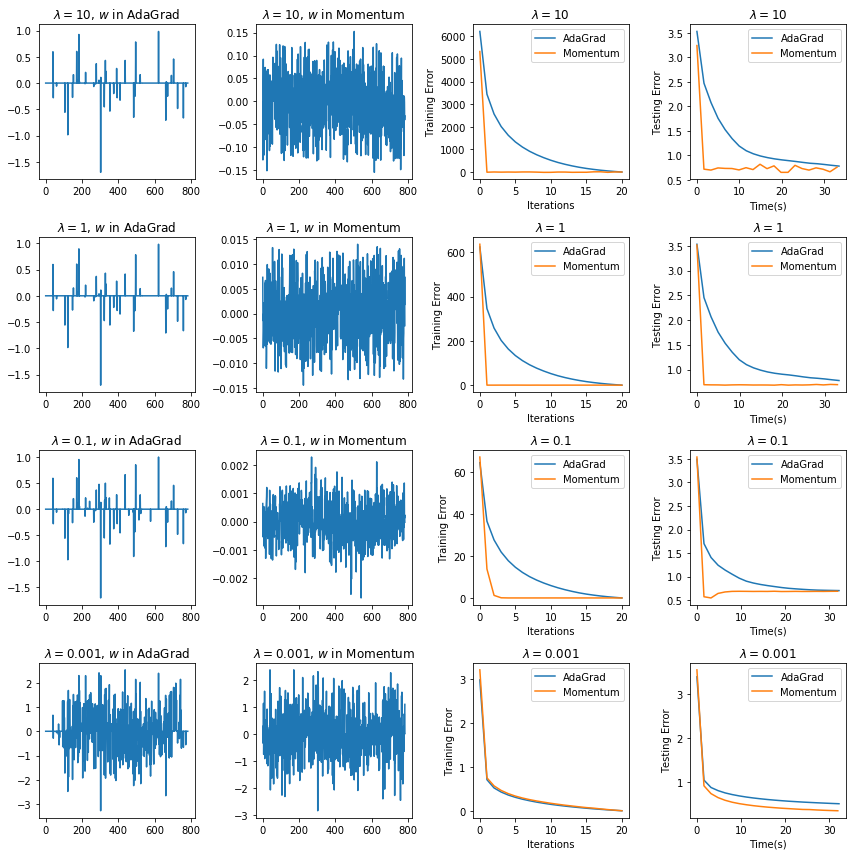

In [8]:
fig, axes = plt.subplots(len(lamdas), 4, figsize=(12,len(lamdas)*3))

for i, ax in enumerate(axes):
    w1, w2 = w1_adag[i], w1_mom[i]
    arg1, arg2 = args1_adag[i], args1_mom[i]
    ax[0].set_title("$\lambda=$%g, $w$ in AdaGrad" % lamdas[i])
    ax[1].set_title("$\lambda=$%g, $w$ in Momentum" % lamdas[i])
    ax[0].plot(w1)
    ax[1].plot(w2)

    ax[2].plot(arg1[:,0],arg1[:,2],label='AdaGrad')
    ax[2].plot(arg2[:,0],arg2[:,2],label='Momentum')
    ax[2].set_title("$\lambda=$%g" % lamdas[i])
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('Training Error')
    ax[2].legend(loc=1)

    ax[3].plot(arg1[:,1],arg1[:,3],label='AdaGrad')
    ax[3].plot(arg2[:,1],arg2[:,3],label='Momentum')
    ax[3].set_title("$\lambda=$%g" % lamdas[i])
    ax[3].set_xlabel('Time(s)')
    ax[3].set_ylabel('Testing Error')
    ax[3].legend(loc=1)
    
fig.tight_layout()

#### Accuracy

我们使用$w^\mathrm{T}X$的符号作为输出标签和输入标签$y$进行比较。我们可以通过如下方法得到预测值的Accuracy:

In [9]:
for i, lamda in enumerate(lamdas):
    rs = np.sign(np.dot(w1_adag[i], test1_x))
    acc = np.mean(np.equal(rs, test1_y))
    print("lambda = %g, AdaGrad Accuracy: %g" % (lamda, acc))
    rs = np.sign(np.dot(w1_mom[i], test1_x))
    acc = np.mean(np.equal(rs, test1_y))
    print("lambda = %g, Momentum Accuracy: %g" % (lamda, acc))

lambda = 10, AdaGrad Accuracy: 0.4899
lambda = 10, Momentum Accuracy: 0.4761
lambda = 1, AdaGrad Accuracy: 0.4929
lambda = 1, Momentum Accuracy: 0.4719
lambda = 0.1, AdaGrad Accuracy: 0.5789
lambda = 0.1, Momentum Accuracy: 0.6733
lambda = 0.001, AdaGrad Accuracy: 0.8385
lambda = 0.001, Momentum Accuracy: 0.8635


在MNIST数据集上，Accuracy结果如下表：

|$\lambda$      |   10    |    1    |   0.1   |  0.001  |
|:-------------:|:-------:|:-------:|:-------:|:-------:| 
| **AdaGrad**   | 0.4899  | 0.4929  | 0.5789  | 0.8385  |
| **Momentum**  | 0.4761  | 0.4719  | 0.6733  | 0.8635  |

正如我们之前所知的，如果将控制$\ell_1$范数的权重$\lambda$设置的过大，分类器将得到一个糟糕的分类效果。当$\lambda$为0.001时，Momentum算法的效果稍好于AdaGrad。

### Covertype

The Forest CoverType dataset是UCI提供的一个对美国森林覆盖类型进行分类的数据集。Covertype数据集包括581012个数据，每个数据是一个54维向量。Covertype数据集是一个多分类问题，[这里](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html)提供了将Covertype转化为二分类的数据集。我使用的数据集从[这里](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#covtype.binary)下载，并把label变为$y\in\{-1,1\}$。下载的数据集已经将数据标准化到[0,1]，因此我没有再进行标准化。我们按照论文的描述，随机选取70%的数据作为训练集，30%作为测试集。

In [10]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('covertype.csv',header=None).values
X = data[:,1:]
y = data[:,0]

train2_x, test2_x, train2_y, test2_y= train_test_split(
    X, y, test_size=0.3, random_state=42)

train2_x = train2_x.T
test2_x = test2_x.T

####  Test a few choices of $\lambda$(10, 1, 0.1, 0.001)

对于AdaGrad和Momentum两个算法，我们均设置迭代步数为10000次，minibatch大小为200，stepsize为1e-2。我们使用numpy.random.randn()将$w$初始化为均值$\mu = 0$，方差$\sigma^2 = 1$的正态分布。

In [11]:
w0_2 = np.random.randn(train2_x.shape[0])

data2 = (train2_x, train2_y, test2_x, test2_y)
lamdas = [10,1,0.1,0.001]
w2_adag, w2_mom = [],[]
args2_adag, args2_mom = [],[]

for lamda in lamdas:
    print("lambda=%g, AdaGrad" % lamda)
    w, args = adagrad(w0_2,train2_x,train2_y,lamda,max_it=10000,minibatchsize=200)
    w2_adag.append(w)
    args = gen_err(data2,lamda,w,args)
    args2_adag.append(args)
    
    print("lambda=%g, Momentum" % lamda)
    w, args = momentum(w0_2,train2_x,train2_y,lamda,max_it=10000,minibatchsize=200)
    w2_mom.append(w)
    args = gen_err(data2,lamda,w,args)
    args2_mom.append(args)

lambda=10, AdaGrad
lambda=10, Momentum
lambda=1, AdaGrad
lambda=1, Momentum
lambda=0.1, AdaGrad
lambda=0.1, Momentum
lambda=0.001, AdaGrad
lambda=0.001, Momentum


#### Generate figures

从下图我们可以看到，相比起MNIST数据集（784维），Covertype的维度更低（54维），因此得到的稀疏效果更好。同样的，在Covertype数据集上，Momentum算法的收敛速度也快于AdaGrad算法。

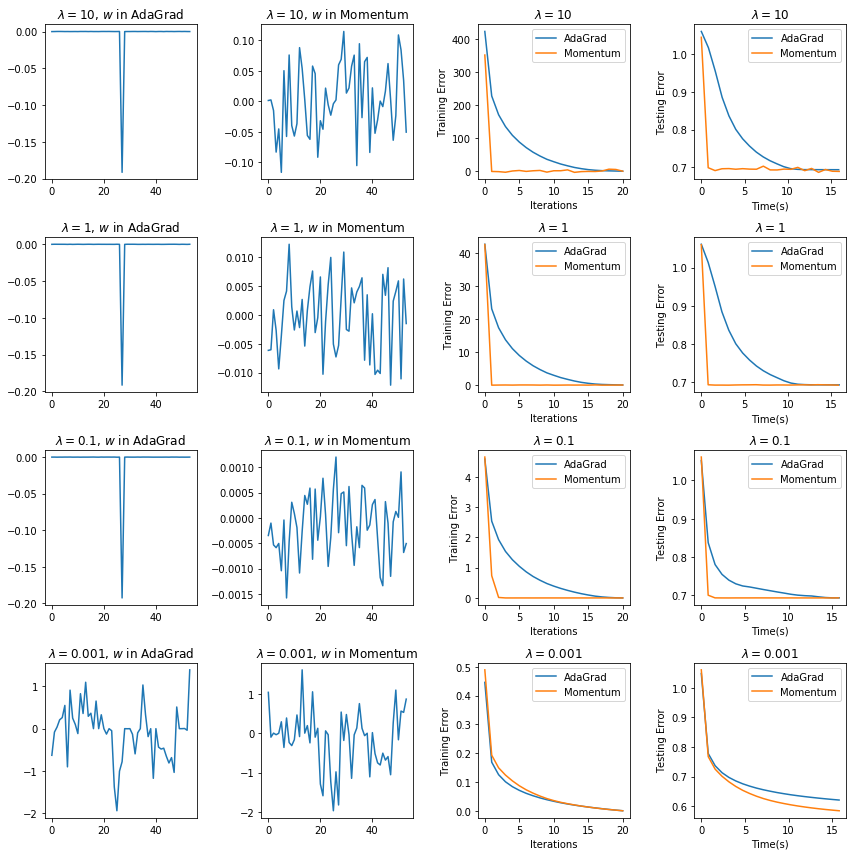

In [12]:
fig, axes = plt.subplots(len(lamdas), 4, figsize=(12,len(lamdas)*3))

for i, ax in enumerate(axes):
    w1, w2 = w2_adag[i], w2_mom[i]
    arg1, arg2 = args2_adag[i], args2_mom[i]
    ax[0].set_title("$\lambda=$%g, $w$ in AdaGrad" % lamdas[i])
    ax[1].set_title("$\lambda=$%g, $w$ in Momentum" % lamdas[i])
    ax[0].plot(w1)
    ax[1].plot(w2)

    ax[2].plot(arg1[:,0],arg1[:,2],label='AdaGrad')
    ax[2].plot(arg2[:,0],arg2[:,2],label='Momentum')
    ax[2].set_title("$\lambda=$%g" % lamdas[i])
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('Training Error')
    ax[2].legend(loc=1)

    ax[3].plot(arg1[:,1],arg1[:,3],label='AdaGrad')
    ax[3].plot(arg2[:,1],arg2[:,3],label='Momentum')
    ax[3].set_title("$\lambda=$%g" % lamdas[i])
    ax[3].set_xlabel('Time(s)')
    ax[3].set_ylabel('Testing Error')
    ax[3].legend(loc=1)
    
fig.tight_layout()

#### Accuracy

In [13]:
for i, lamda in enumerate(lamdas):
    rs = np.sign(np.dot(w2_adag[i], test2_x))
    acc = np.mean(np.equal(rs, test2_y))
    print("lambda = %g, AdaGrad Accuracy: %g" % (lamda, acc))
    rs = np.sign(np.dot(w2_mom[i], test2_x))
    acc = np.mean(np.equal(rs, test2_y))
    print("lambda = %g, Momentum Accuracy: %g" % (lamda, acc))

lambda = 10, AdaGrad Accuracy: 0.511061
lambda = 10, Momentum Accuracy: 0.535358
lambda = 1, AdaGrad Accuracy: 0.49778
lambda = 1, Momentum Accuracy: 0.598667
lambda = 0.1, AdaGrad Accuracy: 0.513608
lambda = 0.1, Momentum Accuracy: 0.488084
lambda = 0.001, AdaGrad Accuracy: 0.65111
lambda = 0.001, Momentum Accuracy: 0.688223


在Covertype数据集上，Accuracy结果如下表：

|$\lambda$      |   10    |    1    |   0.1   |  0.001  |
|:-------------:|:-------:|:-------:|:-------:|:-------:| 
| **AdaGrad**   | 0.5111  | 0.4978  | 0.5136  | 0.6511  |
| **Momentum**  | 0.5353  | 0.5987  | 0.4881  | 0.6882  |

可以看到，在Covertype数据集上分类器的表现并不好。可能是迭代步数不够，$R(w)$没有完全收敛。

## Extra-credit: stochastic gradient method using line search

### Armijo rules

Armijo准则是指：给定$\beta\in(0,1)$, $\sigma\in(0,0.5)$。令步长因子$\alpha_k = \beta^{m_k}$，其中$m_k$是满足下列不等式的最小非负整数：
$$
\tag{1.3} f(x_k+\beta^m d_k)\leq f(x_k)+\sigma\beta^m g_k^T d_k
$$
可以证明，若$f(x)$是连续可微的且满足$g_k^T d_k < 0$，则Armijo准则是有限终止的，即存在正数$\sigma$，使得对于充分大的正整数m,$(1.3)$式成立。

这里使用Armijo准则作为线搜索的搜索条件。由于在多次迭代中搜索的代价很高，我们这里将搜索的迭代上限设置为15，减少搜索时的迭代次数。

In [14]:
# armijo Judge whether Data satisfy the Armijo Criterion and the
# basic criterion in inexact line search
def armijo(wk, dk, x, y, lamda, grad, mk=1):
    beta = 0.5
    sigma = 0.2
    mmax = 15
    # Important step! Accelerate!!
    for mk in xrange(mk,mmax+1):
        stepsize = beta**mk
        if mk == mmax:
            break
        newwk = wk+stepsize*dk
        if Rw(newwk,x,y,lamda) <= Rw(wk,x,y,lamda)+sigma*stepsize*np.dot(grad, dk):
            break
    return stepsize,mk

### AdaGrad using Armijo back tracking line search 

为了减少迭代中的搜索次数、提高计算速度，我们采用一种加速策略。对于一个强凸函数，要求$\mathrm{stepsize}_t \leq \mathrm{stepsize}_{t-1}$，减少无用的搜索。

In [15]:
# AdaGrad with line search
def adagrad_line_search(w0,x,y,lamda,fudge_factor=1e-6,
            max_it=1000,minibatchsize=None,minibatch_ratio=0.01):
    
    d, ld = x.shape
    #d-dimensional vector representing diag(Gt) to store a running total of the squares of the gradients.
    gti=np.zeros(d)
    
    if minibatchsize is None:
        minibatchsize = int(math.ceil(ld*minibatch_ratio))
    w=w0
    args=[]
    idx = int(max_it/20) if int(max_it/20) > 0 else 1
    mk = 1
    tic()
    for t in range(max_it+1):
        s=sample(xrange(ld),minibatchsize)
        x_= x[np.ix_(range(d),s)]
        y_= y[s]
        grad=g_grad(w, x_, y_, lamda)
        
        gti+=grad**2
        dk = -grad / (fudge_factor + np.sqrt(gti))
        ## !!!!
        stepsize,mk = armijo(w,dk,x_,y_,lamda,grad,mk)
        w = w + stepsize*dk
        
        if t % idx is 0:
            
            tt = toc()
            args.append([t/idx, tt, w])
        
    return w, args

####  Test a few choices of $\lambda$(10, 1, 0.1, 0.001)

由于线搜索的时间代价较高，这里的数值实验只使用了MNIST数据集（下同）。在训练和测试时，我们选择的超参数和初始化$w$的策略与不使用线搜索的算法相同。

In [16]:
lamdas = [10,1,0.1,0.001]
w1_adag_ls = []
args1_adag_ls = []

for lamda in lamdas:
    print("lambda=%g, AdaGrad with Line Search" % lamda)
    w, args = adagrad_line_search(w0_1,train1_x,train1_y,
                                  lamda,max_it=10000,minibatchsize=50)
    w1_adag_ls.append(w)
    args = gen_err(data1,lamda,w,args)
    args1_adag_ls.append(args)   

lambda=10, AdaGrad with Line Search
lambda=1, AdaGrad with Line Search
lambda=0.1, AdaGrad with Line Search
lambda=0.001, AdaGrad with Line Search


#### Generate figures

可以看到，对于AdaGrad算法，使用了线搜索策略后收敛速度得到了明显提升。在和不使用线搜索策略保持相同的参数下，最终收敛的error值也更低。使用线搜索迭代相同的次数，在速度方面比起不使用线搜索没有变慢很多(+5s)。

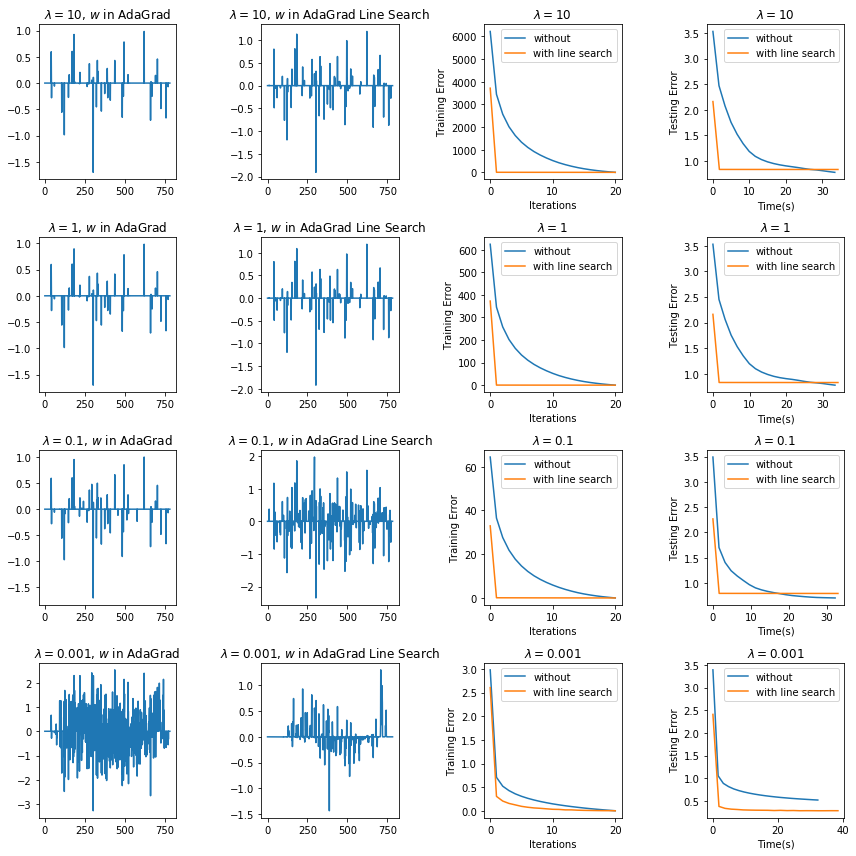

In [17]:
fig, axes = plt.subplots(len(lamdas), 4, figsize=(12,len(lamdas)*3))

for i, ax in enumerate(axes):
    w1, w2 = w1_adag[i], w1_adag_ls[i]
    arg1, arg2 = args1_adag[i], args1_adag_ls[i]
    ax[0].set_title("$\lambda=$%g, $w$ in AdaGrad" % lamdas[i])
    ax[1].set_title("$\lambda=$%g, $w$ in AdaGrad Line Search" % lamdas[i])
    ax[0].plot(w1)
    ax[1].plot(w2)

    ax[2].plot(arg1[:,0],arg1[:,2],label='without')
    ax[2].plot(arg2[:,0],arg2[:,2],label='with line search')
    ax[2].set_title("$\lambda=$%g" % lamdas[i])
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('Training Error')
    ax[2].legend(loc=1)

    ax[3].plot(arg1[:,1],arg1[:,3],label='without')
    ax[3].plot(arg2[:,1],arg2[:,3],label='with line search')
    ax[3].set_title("$\lambda=$%g" % lamdas[i])
    ax[3].set_xlabel('Time(s)')
    ax[3].set_ylabel('Testing Error')
    ax[3].legend(loc=1)
    
fig.tight_layout()

#### Accuracy

使用了线搜索的AdaGrad算法相比不使用线搜索的AdaGrad算法，在相同的参数下，Accuracy均有一些提升。

In [18]:
for i, lamda in enumerate(lamdas):
    rs = np.sign(np.dot(w1_adag[i], test1_x))
    acc = np.mean(np.equal(rs, test1_y))
    print("lambda = %g, AdaGrad Accuracy: %g" % (lamda, acc))
    rs = np.sign(np.dot(w1_adag_ls[i], test1_x))
    acc = np.mean(np.equal(rs, test1_y))
    print("lambda = %g, AdaGrad Line Search Accuracy: %g" % (lamda, acc))

lambda = 10, AdaGrad Accuracy: 0.4899
lambda = 10, AdaGrad Line Search Accuracy: 0.5011
lambda = 1, AdaGrad Accuracy: 0.4929
lambda = 1, AdaGrad Line Search Accuracy: 0.5122
lambda = 0.1, AdaGrad Accuracy: 0.5789
lambda = 0.1, AdaGrad Line Search Accuracy: 0.6732
lambda = 0.001, AdaGrad Accuracy: 0.8385
lambda = 0.001, AdaGrad Line Search Accuracy: 0.8874


在MNIST数据集上，Accuracy结果如下表：

|$\lambda$      |   10    |    1    |   0.1   |  0.001  |
|:-------------:|:-------:|:-------:|:-------:|:-------:| 
| **AdaGrad**   | 0.4899  | 0.4929  | 0.5789  | 0.8385  |
| **AdaGrad Line Search**   | 0.5011  | 0.5122  | 0.6732  | 0.8874  |
| **Momentum**  | 0.4761  | 0.4719  | 0.6733  | 0.8635  |

### Momentum using Armijo back tracking line search 

In [19]:
# Momentum
def momentum_line_search(w0,x,y,lamda,rho=0.5,
             max_it=1000,minibatchsize=None,minibatch_ratio=0.01):
    
    d, ld = x.shape
    #d-dimensional vector to store old gradients.
    delta_w=np.zeros(d)
    
    if minibatchsize is None:
        minibatchsize = int(math.ceil(ld*minibatch_ratio))
    w=w0
    args=[]
    idx = int(max_it/20) if int(max_it/20) > 0 else 1
    mk = 1
    tic()
    for t in range(max_it+1):
        s=sample(xrange(ld),minibatchsize)
        x_= x[np.ix_(range(d),s)]
        y_= y[s]
        
        grad=g_grad(w, x_, y_, lamda)
        dk = -grad
        stepsize,mk = armijo(w,dk,x_,y_,lamda,grad,mk)
        
        delta_w = rho*delta_w + stepsize*dk
        w = w + delta_w
       
        if t % idx is 0:
            tt = toc()
            args.append([t/idx, tt, w])
        
    return w, args

####  Test a few choices of $\lambda$(10, 1, 0.1, 0.001)

In [20]:
lamdas = [10,1,0.1,0.001]
w1_mom_ls = []
args1_mom_ls = []

for lamda in lamdas:
    print("lambda=%g, AdaGrad with Line Search" % lamda)
    w, args = momentum_line_search(w0_1,train1_x,train1_y,
                                  lamda,max_it=10000,minibatchsize=50)
    w1_mom_ls.append(w)
    args = gen_err(data1,lamda,w,args)
    args1_mom_ls.append(args)   

lambda=10, AdaGrad with Line Search
lambda=1, AdaGrad with Line Search
lambda=0.1, AdaGrad with Line Search
lambda=0.001, AdaGrad with Line Search


#### Generate figures

可以看到，对于Momentum算法，使用了线搜索策略后收敛速度没有明显提升。分析发现，在AadGrad算法中，error是逐渐收敛的，因此使用非精准搜索步长可以避免无效震荡，提高收敛速度。而在Momentum算法中，由于很快error便有一个急速的下降，因此使用了线搜索得到的步长也没有明显提高收敛速度。在和不使用线搜索策略保持相同的参数下，最终收敛的error值也更低。和AadGrad算法一样，使用线搜索迭代相同的次数，在速度方面比起不使用线搜索没有变慢很多(+5s)。

我们还可以观察到，当$\lambda = 0.1$和$\lambda = 0.001$时，使用线搜索得到的$w$比起不使用要更稀疏。

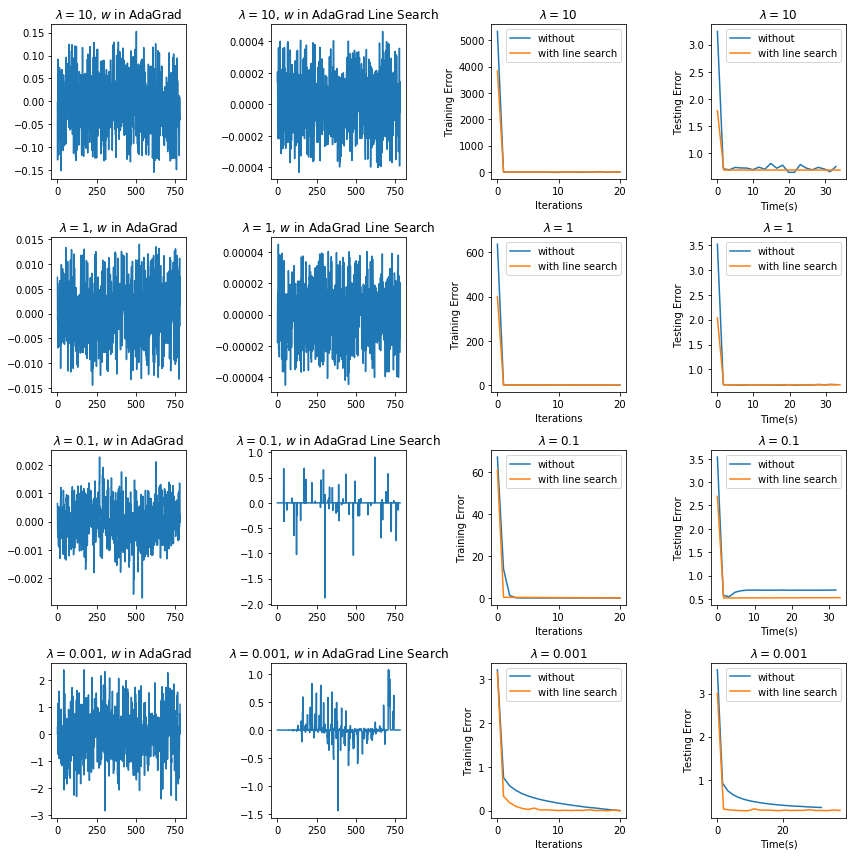

In [21]:
fig, axes = plt.subplots(len(lamdas), 4, figsize=(12,len(lamdas)*3))

for i, ax in enumerate(axes):
    w1, w2 = w1_mom[i], w1_mom_ls[i]
    arg1, arg2 = args1_mom[i], args1_mom_ls[i]
    ax[0].set_title("$\lambda=$%g, $w$ in AdaGrad" % lamdas[i])
    ax[1].set_title("$\lambda=$%g, $w$ in AdaGrad Line Search" % lamdas[i])
    ax[0].plot(w1)
    ax[1].plot(w2)

    ax[2].plot(arg1[:,0],arg1[:,2],label='without')
    ax[2].plot(arg2[:,0],arg2[:,2],label='with line search')
    ax[2].set_title("$\lambda=$%g" % lamdas[i])
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('Training Error')
    ax[2].legend(loc=1)

    ax[3].plot(arg1[:,1],arg1[:,3],label='without')
    ax[3].plot(arg2[:,1],arg2[:,3],label='with line search')
    ax[3].set_title("$\lambda=$%g" % lamdas[i])
    ax[3].set_xlabel('Time(s)')
    ax[3].set_ylabel('Testing Error')
    ax[3].legend(loc=1)
    
fig.tight_layout()

#### Accuracy

使用了线搜索的Momentum算法相比不使用线搜索的Momentum算法，在相同的参数下，当$\lambda$较小时，Accuracy有一些提升。当$\lambda$较大时，Accuracy略有下降。

In [22]:
for i, lamda in enumerate(lamdas):
    rs = np.sign(np.dot(w1_mom[i], test1_x))
    acc = np.mean(np.equal(rs, test1_y))
    print("lambda = %g, AdaGrad Accuracy: %g" % (lamda, acc))
    rs = np.sign(np.dot(w1_mom_ls[i], test1_x))
    acc = np.mean(np.equal(rs, test1_y))
    print("lambda = %g, AdaGrad Line Search Accuracy: %g" % (lamda, acc))

lambda = 10, AdaGrad Accuracy: 0.4761
lambda = 10, AdaGrad Line Search Accuracy: 0.4746
lambda = 1, AdaGrad Accuracy: 0.4719
lambda = 1, AdaGrad Line Search Accuracy: 0.456
lambda = 0.1, AdaGrad Accuracy: 0.6733
lambda = 0.1, AdaGrad Line Search Accuracy: 0.7656
lambda = 0.001, AdaGrad Accuracy: 0.8635
lambda = 0.001, AdaGrad Line Search Accuracy: 0.8846


在MNIST数据集上，Accuracy结果如下表：

|$\lambda$      |   10    |    1    |   0.1   |  0.001  |
|:-------------:|:-------:|:-------:|:-------:|:-------:| 
| **AdaGrad**   | 0.4899  | 0.4929  | 0.5789  | 0.8385  |
| **AdaGrad Line Search**   | 0.5011  | 0.5122  | 0.6732  | 0.8874  |
| **Momentum**  | 0.4761  | 0.4719  | 0.6733  | 0.8635  |
| **Momentum Line Search**  | 0.4746  | 0.456  | 0.7656  | 0.8846  |